In [207]:
#import tensorflow as tf
#import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk

import re
import os

### Actions performed
#### Prototype how to load the wall street journal data. 
#### Evaluation methods to compare trees
#### comparison with google word vectors and convert words which are not there to UNK or some other symbol

# Load training and test dataset

#### Use BracketParse corpus reader to load the wall street journal data
#### functions subtrees(), label(), leaves() are important
#### checkout load-penn-treebank-dataset.py for protoypes

In [208]:
dirname = os.getcwd()
dirname = os.path.dirname(dirname)
dataset_path = os.path.join(dirname, 'datasets/')
print(dataset_path)

/media/kandy/hdd/master-thesis/constituency-parsing/datasets/


In [209]:
## https://www.nltk.org/_modules/nltk/tree.html
## http://www.nltk.org/howto/tree.html
## above link contains the API and also some tutorials

#reader = nltk.corpus.BracketParseCorpusReader('.','SWB-all-sentences-original-with-punctuation.MRG')
reader = nltk.corpus.BracketParseCorpusReader(dataset_path,'WSJ.txt')
print(reader.fileids())
print(type(reader))

## reads the file and converts each line into a tree
trees = reader.parsed_sents()
print('No. of trees: ', len(trees))
print(type(trees[0]))

['WSJ.txt']
<class 'nltk.corpus.reader.bracket_parse.BracketParseCorpusReader'>
No. of trees:  49208
<class 'nltk.tree.Tree'>


### Evaluation methods to compare trees
#### equality operator (==) is good enough to compare trees. When comparing both the tree and tree label is taken into account
#### Initial methods will not have categorization classification technique. So, it is important to replace all the values with say UNK symbol of google corpus
#### It is created in such a way that subcategories of punctuations are named by itself

## Preprocess Tree to chomsky normal form, collapse unary and make it UNLabelled

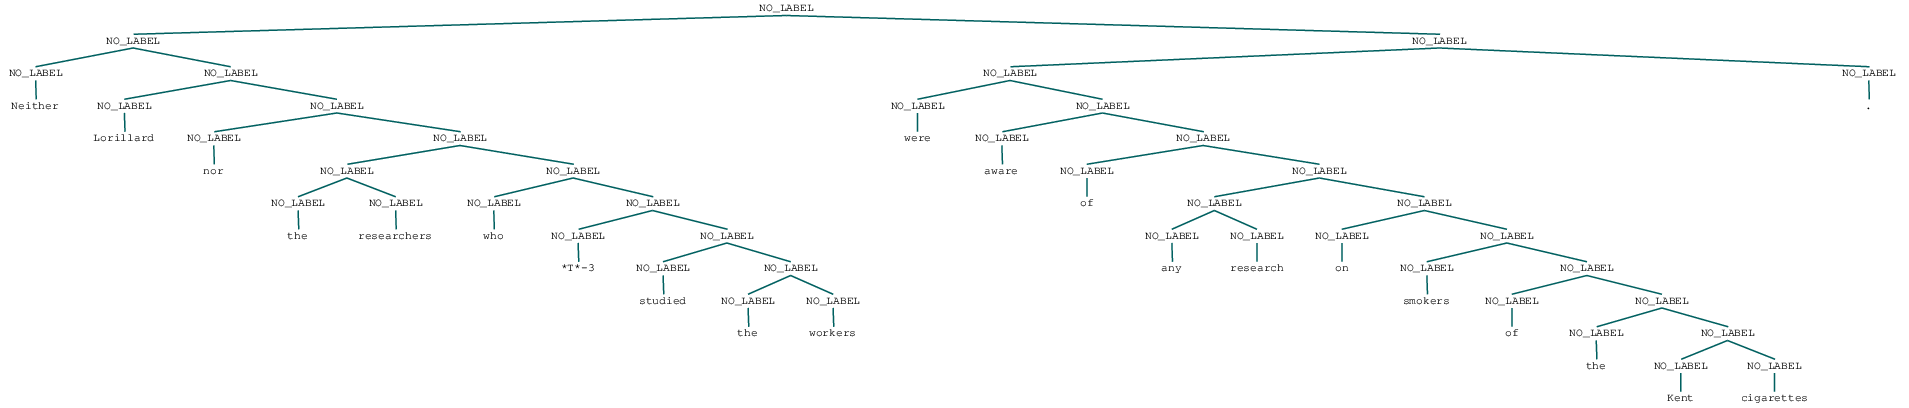

In [210]:
NO_LABEL = 'NO_LABEL'

def set_no_label(tree):
    if(type(tree[0]) == type('a string')):
        # we have reached the bottom most parent
        tree.set_label(NO_LABEL)
        return
   
    # accesses the left child
    set_no_label(tree[0])
    
    # accesses the right child
    set_no_label(tree[1])

    tree.set_label(NO_LABEL)
    

def preprocess_tree(tree):
    
    # set chomsky normal form
    tree.chomsky_normal_form()
    # merge the unary branches
    tree.collapse_unary(collapsePOS=True, collapseRoot=True)
    # set the label with 'NO_LABEL'
    set_no_label(tree)
    
#temp_trees = [preprocess_tree(tree) for tree in trees]
#temp_trees[0]
tree = trees[10]
preprocess_tree(tree)
tree

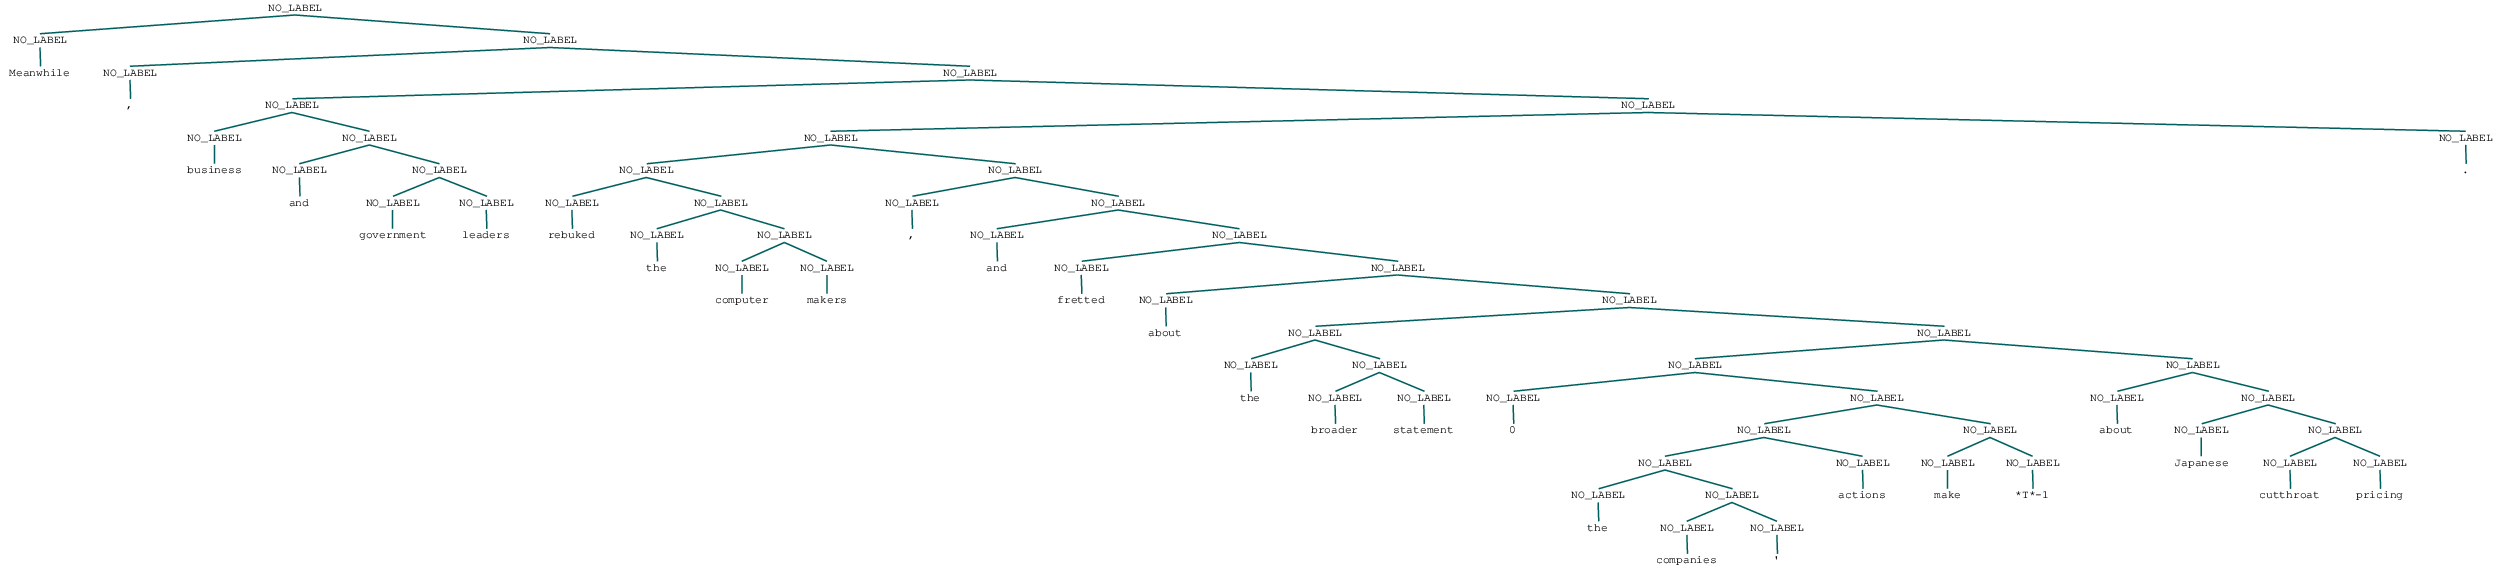

In [211]:
preprocessed_trees = []
for i in range(len(trees)):
    tree = trees[i]
    preprocess_tree(tree)
    preprocessed_trees.append(tree)
    
preprocessed_trees[1000]

### Convert the words which does not appear in Google word embeddings with UNK or other symbol
As suggested in 'check-embeddings-wallstreet-coverage' google word embeddings are better than glove embeddings

In [212]:
UNK = '</s>'
FILLER = '</fill>'

outfile = dataset_path +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(dataset_path+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

print(googleSet.shape)
print(googleSet.head())

# TO BE DONE - Appropriate value should be added for FILLER
fill_data = {0:FILLER}
for i in range(1, googleSet.shape[1]):
    fill_data[i] = i
googleSet = googleSet.append(fill_data, ignore_index=True)

print(googleSet.shape)
print(googleSet.head())

temp = list(googleCorpus)
temp.append(FILLER)
googleCorpus = set(temp)
corpus_length = len(google_corpus_word_to_int)
google_corpus_word_to_int[FILLER] = corpus_length
google_corpus_int_to_word[corpus_length] = FILLER


googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(1965717, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 -0.018799 -0.007111 -0.139648 -0.046631   
3     $  0.113770 -0.117676  0.064941  0.132812  0.054932 -0.099121  0.071289   
4   ###  0.149414 -0.191406  0.044189  0.104980  0.016846 -0.135742 -0.085449   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.077637  0.199219 -0.001770  
2 -0.063965  0.098145  0.135742  
3 -0.013306  0.271484 -0.083984  
4  0.074219  0.088867 -0.044922  
(1965718, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    ##  0.168945 -0.062988 -0.000265  0.063477  0.087402 -0.030029  0.001450   
2  ####  0.107910  0.094238 -0.018555 

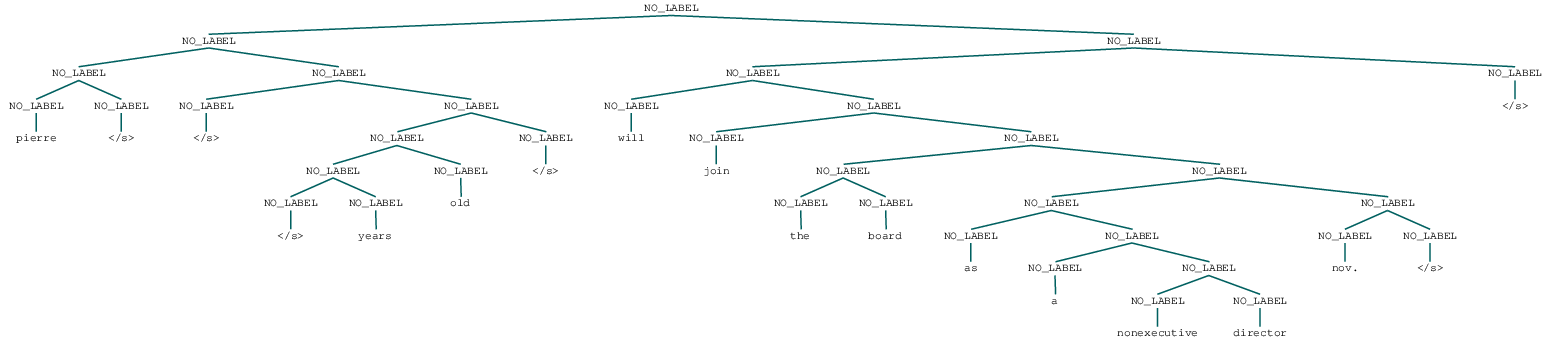

In [213]:
UNK = '</s>' # this is the symbol for UNK in google corpus

def set_UNK(tree):
    if(type(tree[0]) == type('a string')):
        # we have reached the bottom most parent
        tree[0] = tree[0].lower()
        if(tree[0] not in googleCorpus):
            tree[0] = UNK
        return
   
    # accesses the left child
    set_UNK(tree[0])
    
    # accesses the right child
    set_UNK(tree[1])
    
#temp_trees = [preprocess_tree(tree) for tree in trees]
#temp_trees[0]
tree = preprocessed_trees[0]
set_UNK(tree)
tree

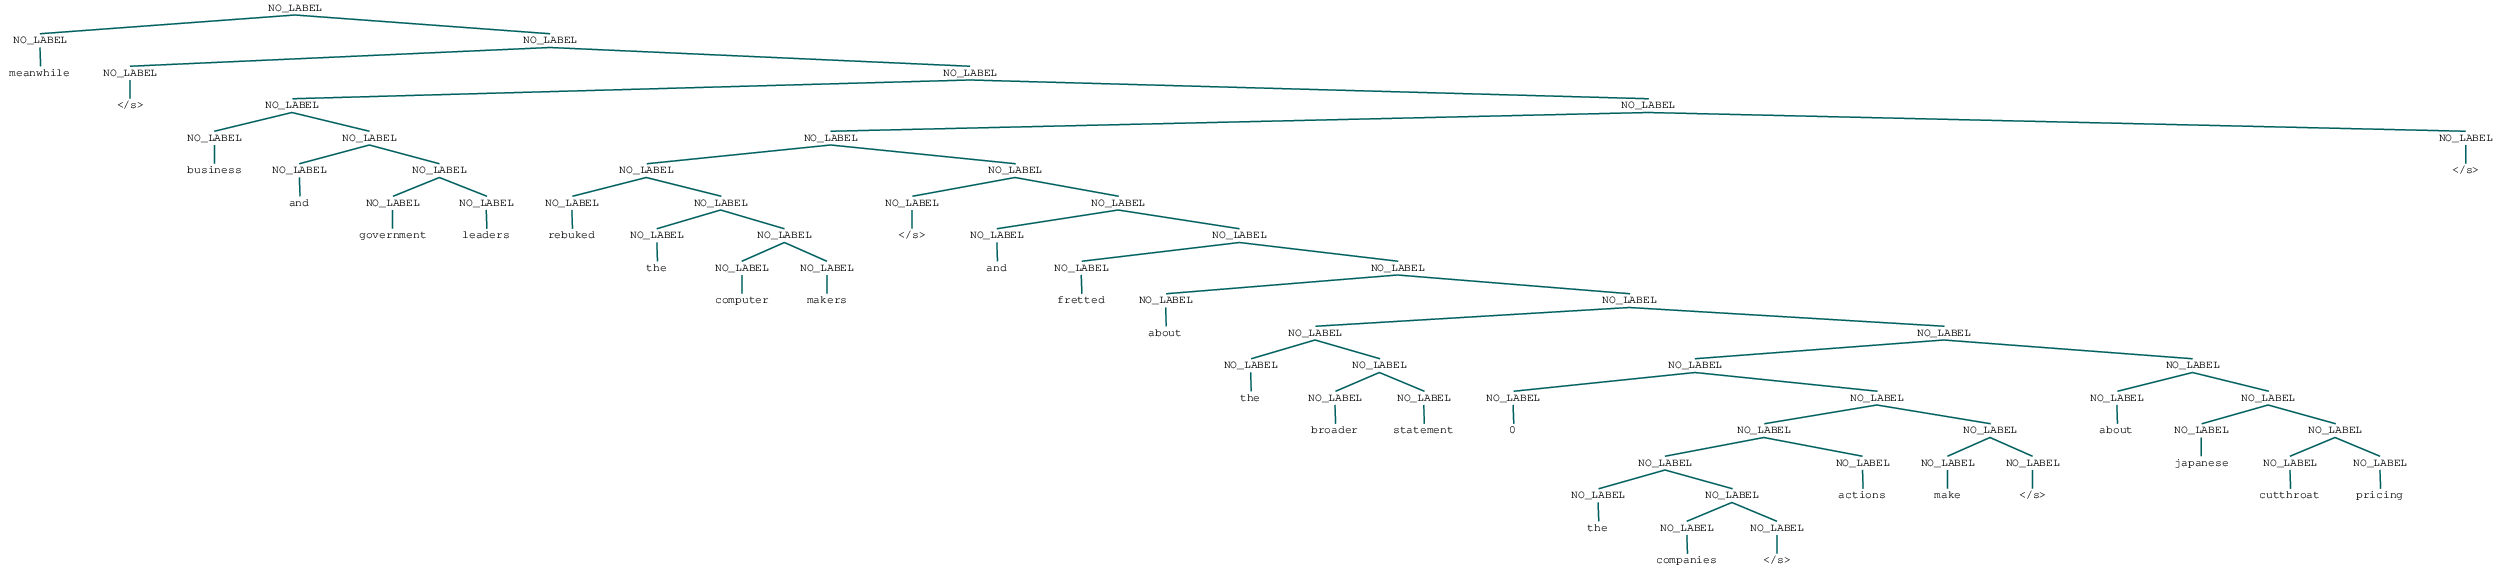

In [215]:
preprocessed_unk_trees = []
for i in range(len(preprocessed_trees)):
    tree = preprocessed_trees[i]
    set_UNK(tree)
    preprocessed_unk_trees.append(tree)
    
preprocessed_unk_trees[1000]

### Only sentences with <= 40 words (<40 words suffix additional words and make it 40)

49208
43834


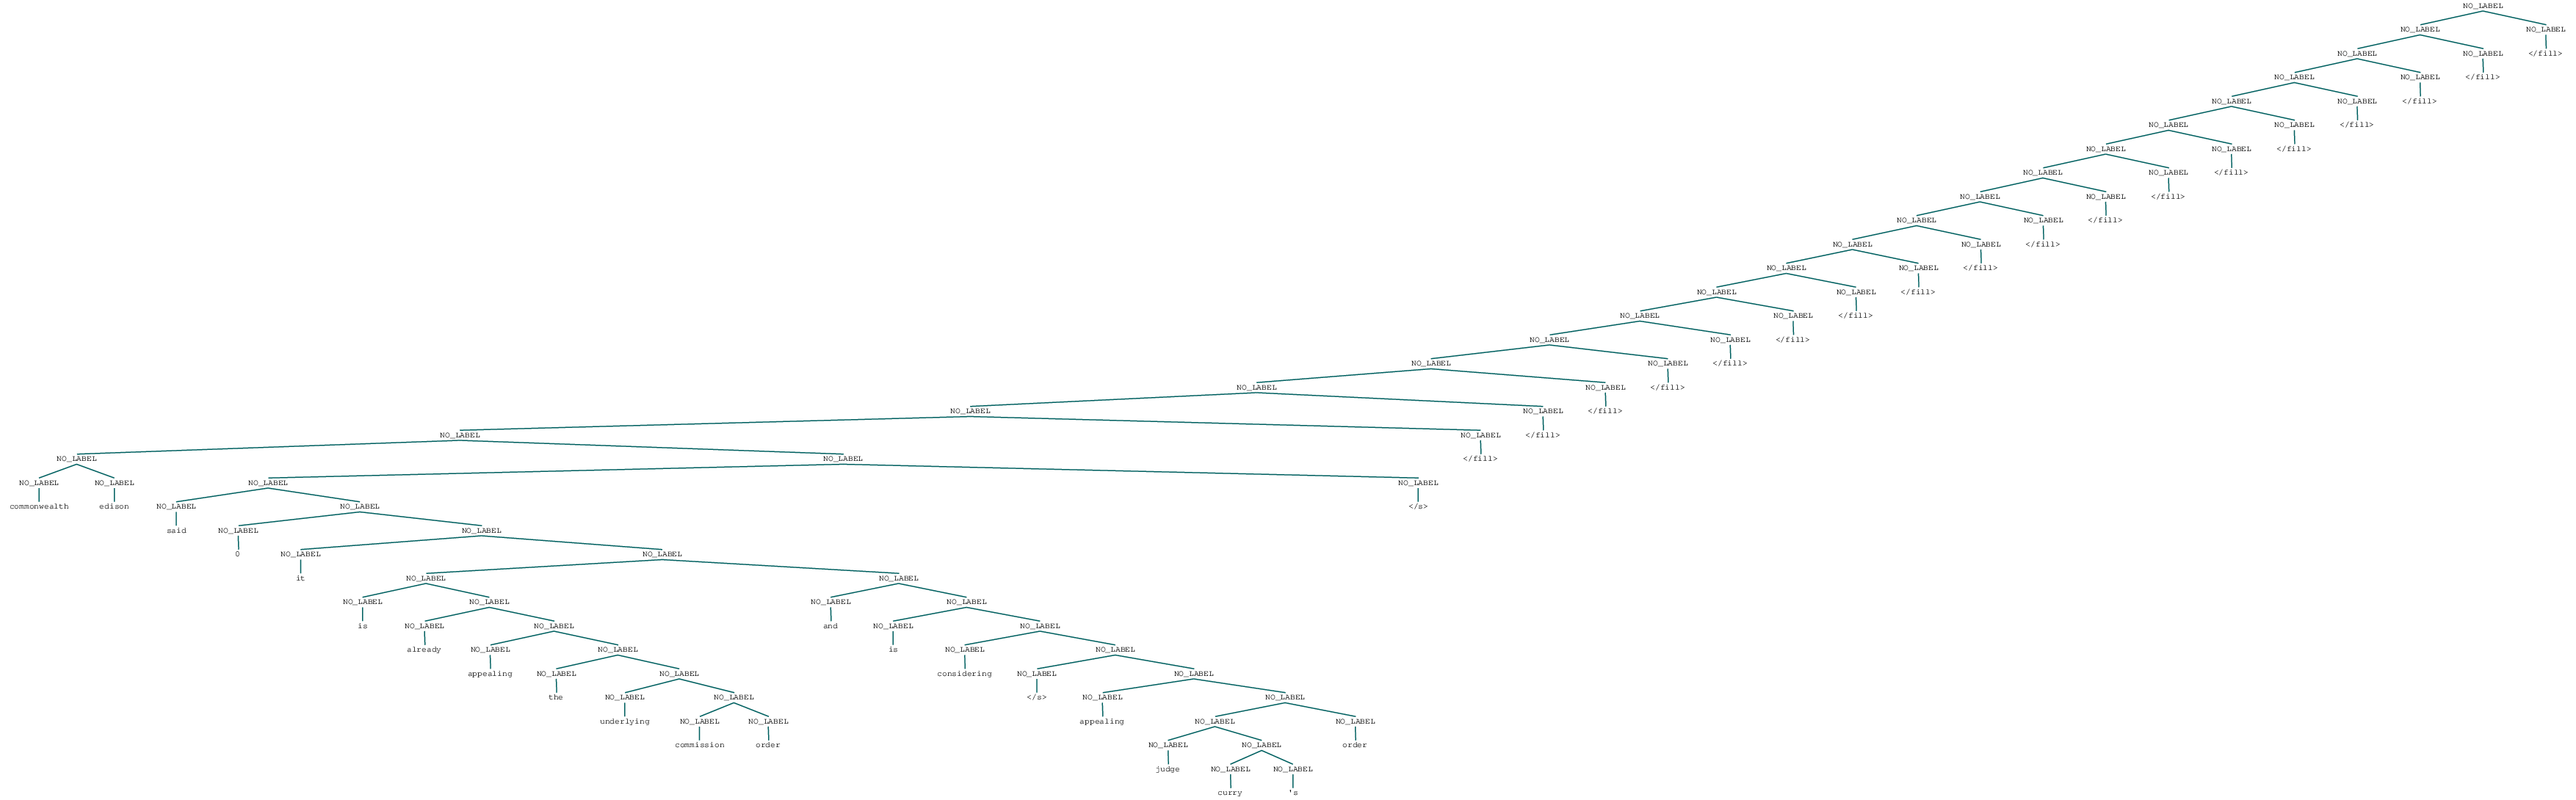

In [216]:
FILLER = '</fill>'
MAX_WORDS_COUNT = 40
preprocessed_unk_40_trees = []
for i in range(len(preprocessed_unk_trees)):
    tree = preprocessed_unk_trees[i]
    words_count = len(tree.leaves())
    if(words_count <= MAX_WORDS_COUNT):
        for i in range(MAX_WORDS_COUNT - words_count):
            tree = nltk.Tree(NO_LABEL, [tree, nltk.Tree(NO_LABEL, [FILLER])])
        preprocessed_unk_40_trees.append(tree)

print(len(preprocessed_unk_trees))
print(len(preprocessed_unk_40_trees))
preprocessed_unk_40_trees[123]

In [217]:
# Serialize it as CSV

treesDict = [{'sentence': ' '.join(tree.leaves()), 'tree':tree} for tree in preprocessed_unk_40_trees]
treeDataframe = pd.DataFrame(data=treesDict, columns=['sentence', 'tree'])
treeDataframe.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
1,mr. </s> is chairman of elsevier n.v. </s> the...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
2,rudolph agnew </s> </s> years old and former c...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
3,the asbestos fiber </s> </s> </s> is unusually...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...
4,lorillard inc. </s> the unit of new </s> loews...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...


In [218]:
treeDataframe.to_csv(dataset_path+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', index=False, header=False)

In [219]:
load_treeData = pd.read_csv(dataset_path+'constituency-parsing-data-40-UNK-NOLABEL.csv', sep=' ', header=None, )
load_treeData.columns =['sentence', 'tree']
load_treeData.head()

,sentence,tree
0,pierre </s> </s> </s> years old </s> will join...,(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n (...
1,mr. </s> is chairman of elsevier n.v. </s> the...,(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n (...
2,rudolph agnew </s> </s> years old and former c...,(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n (...
3,the asbestos fiber </s> </s> </s> is unusually...,(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n (...
4,lorillard inc. </s> the unit of new </s> loews...,(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n (...


In [220]:
print(load_treeData.iat[0,1])
print(type(load_treeData.iat[0,1]))

(NO_LABEL
  (NO_LABEL
    (NO_LABEL
      (NO_LABEL
        (NO_LABEL
          (NO_LABEL
            (NO_LABEL
              (NO_LABEL
                (NO_LABEL
                  (NO_LABEL
                    (NO_LABEL
                      (NO_LABEL
                        (NO_LABEL
                          (NO_LABEL
                            (NO_LABEL
                              (NO_LABEL
                                (NO_LABEL
                                  (NO_LABEL
                                    (NO_LABEL
                                      (NO_LABEL
                                        (NO_LABEL
                                          (NO_LABEL
                                            (NO_LABEL
                                              (NO_LABEL
                                                (NO_LABEL
                                                  (NO_LABEL pierre)
                                                  (NO_LABEL </s>))
               

In [221]:
load_treeData['tree'] = load_treeData['tree'].apply(nltk.Tree.fromstring)
print(load_treeData.iat[0,1])
print(type(load_treeData.iat[0,1]))

(NO_LABEL
  (NO_LABEL
    (NO_LABEL
      (NO_LABEL
        (NO_LABEL
          (NO_LABEL
            (NO_LABEL
              (NO_LABEL
                (NO_LABEL
                  (NO_LABEL
                    (NO_LABEL
                      (NO_LABEL
                        (NO_LABEL
                          (NO_LABEL
                            (NO_LABEL
                              (NO_LABEL
                                (NO_LABEL
                                  (NO_LABEL
                                    (NO_LABEL
                                      (NO_LABEL
                                        (NO_LABEL
                                          (NO_LABEL
                                            (NO_LABEL
                                              (NO_LABEL
                                                (NO_LABEL
                                                  (NO_LABEL pierre)
                                                  (NO_LABEL </s>))
               

In [222]:
load_treeData['length'] = load_treeData['sentence'].apply(lambda x: len(x.split()))
load_treeData.sort_values(by='length',ascending=True, inplace=True)
load_treeData.head()


,sentence,tree,length
0,pierre </s> </s> </s> years old </s> will join...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,40
29217,any secret can be pirated </s> </s> the expert...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,40
29218,even rank amateurs can do it if they spend a f...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,40
29219,they need only </s> position themselves near a...,[[[(NO_LABEL\n (NO_LABEL\n (NO_LABEL\n ...,40
29220,</s> you can have a dozen competitors stealing...,"[[</s>], [[(NO_LABEL you), (NO_LABEL\n (NO_LA...",40
